In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import warnings

<ipython-input-1-470d952dfd29>:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
link = 'dft_traffic_counts_aadf.csv'
raw_df = pd.read_csv(link)

In [3]:
regions = list(set(raw_df['region_id']))
#regions

In [4]:
major_roads = list(np.where(np.array(raw_df['road_type']) == 'Major')[0])
cols = list(np.linspace(20, 32, 13))
cols = [2, 3, 15] + [int(a) for a in cols]
raw_df_summary = raw_df.iloc[major_roads, cols]

In [5]:
mv_summary = {}
mv_summary['Regions'] = regions
for i in cols[3:]:
    listy = []
    for j in regions:
        j_data = raw_df_summary.iloc[np.where(np.array(raw_df_summary['region_id']) == j)[0]]
        total_length = (j_data['link_length_miles'].sum())/21
        total_vehicles = (j_data.iloc[:,i-17].sum())/21
        total_milage = total_length*total_vehicles
        listy.append(total_milage)
    mv_summary[list(raw_df_summary)[i - 17]] = listy


<AxesSubplot:xlabel='Regions'>

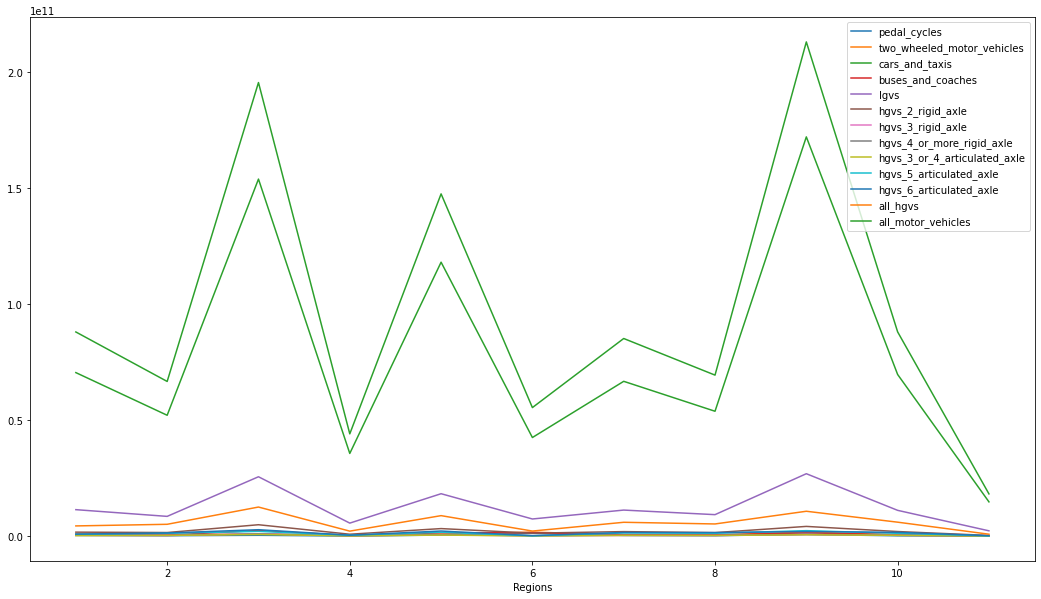

In [6]:
mv_summary_df = pd.DataFrame.from_dict(mv_summary)
mv_summary_df.plot(x = 'Regions', y=list(raw_df_summary)[3:], figsize = (18, 10))

<AxesSubplot:xlabel='Regions'>

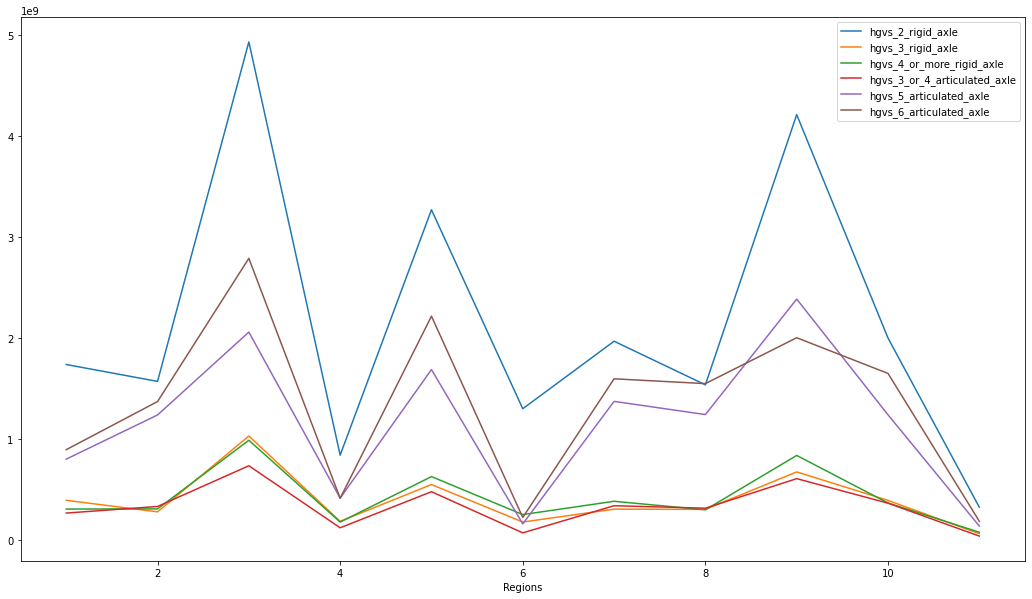

In [7]:
mv_summary_df.plot(x = 'Regions', y=list(raw_df_summary)[8:14], figsize = (18, 10))

In [8]:
raw_df_subset = raw_df.loc[major_roads, ['year', 'region_id', 'link_length_miles', 'all_motor_vehicles']]

In [9]:
years = list(np.linspace(2000, 2019, 20))
years = [int(a) for a in years]
amv_regional = {}
amv_regional['Years'] = years
for i in regions:
    listy = []
    #print(i)
    for j in years:
        #print(j)
        j_data = raw_df_subset.iloc[np.where(np.array(raw_df_subset['year']) == j)[0]]
        i_in_j = j_data.iloc[np.where(np.array(j_data['region_id']) == i)[0]]
        total_length = i_in_j['link_length_miles'].sum()
        total_vehicles = i_in_j['all_motor_vehicles'].sum()
        total_vehicle_milage = total_length*total_vehicles
        listy.append(total_vehicle_milage)
    amv_regional[i] = listy

<AxesSubplot:xlabel='Years'>

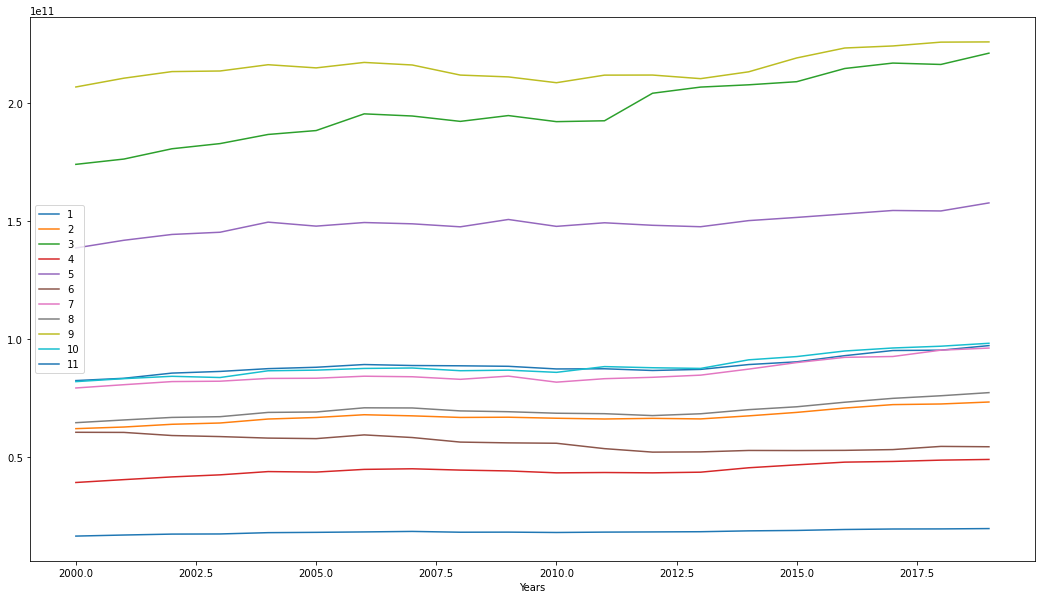

In [10]:
amv_regional_df = pd.DataFrame.from_dict(amv_regional)
amv_regional_df.plot(x = 'Years', y = regions, kind = 'line', figsize = (18, 10))

In [11]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.75)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [12]:
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue
    return best_cfg, best_score

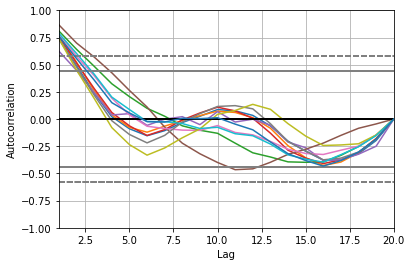

In [13]:
for i in regions:
    autocorrelation_plot(amv_regional_df[i])

In [24]:
# p_values = list(np.linspace(0, 20, 21))
p_values = range(0, 15)
d_values = range(0, 3)
q_values = range(0, 3)
top_cp_orders = {}
for j in regions:
    warnings.filterwarnings("ignore")
    best_order, best_score = evaluate_models(list(amv_regional_df[j]), p_values, d_values, q_values)
    top_cp_orders[j] = [best_order, best_score]

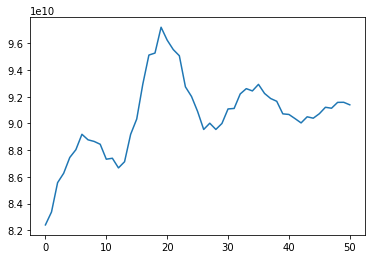

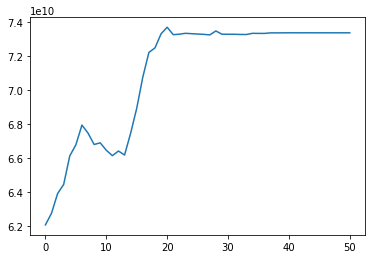

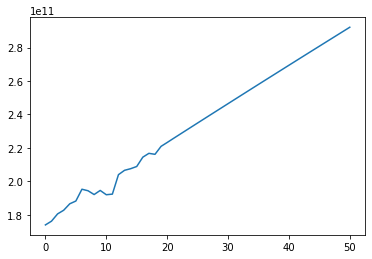

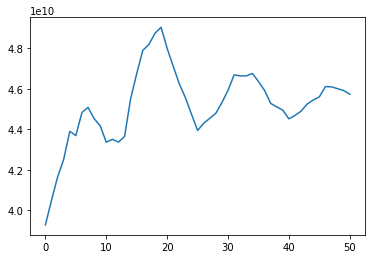

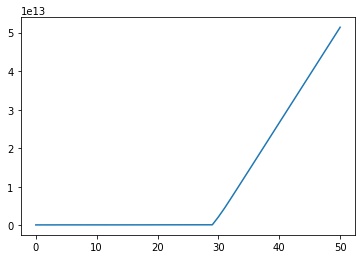

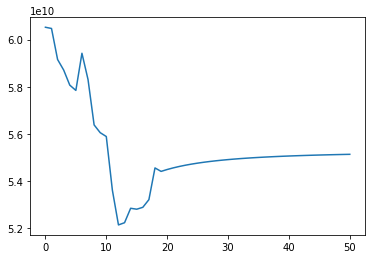

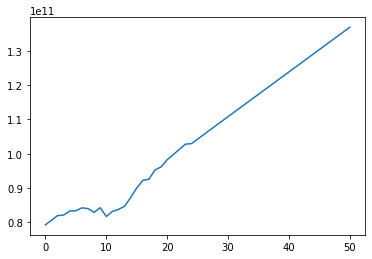

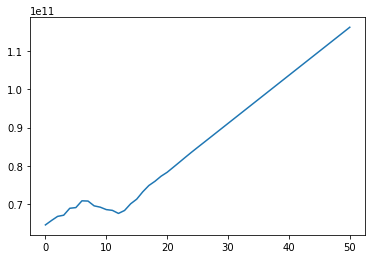

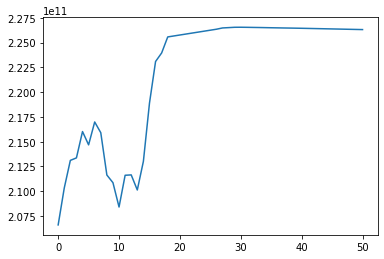

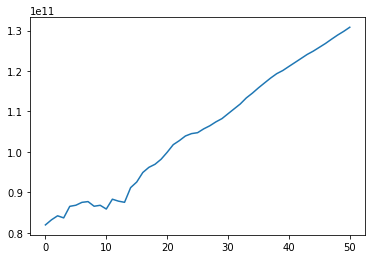

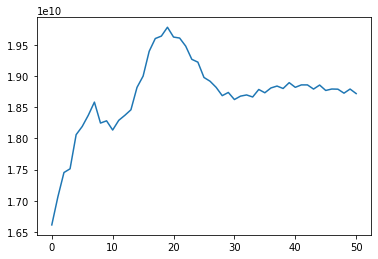

In [26]:
future_years = list(np.linspace(2020, 2050, 31))
future_years = [int(a) for a in future_years]
arima_estimate = {}
arima_estimate['Years'] = future_years
for j in regions:
    history = list(amv_regional_df[j])
    predictions = list()
    for t in future_years:
        model = ARIMA(history, order=top_cp_orders[j][0])
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(yhat)
    arima_estimate[j] = predictions
    plt.figure()
    plt.plot(history)
    plt.show

In [56]:
arima_estimate_df = pd.DataFrame.from_dict(arima_estimate)

In [57]:
miles = [98.409, 97.818, 96.442, 95.454, 93.017, 91.227, 
         88.08, 85.325, 82.57, 78.452, 72.915, 67.983, 
         62.076, 55.582, 50.264, 44.756, 38.783, 33.286, 
         28.956, 24.627, 20.689, 16.753, 13.457, 11.485, 
         9.124, 7.156, 6.166, 4.988, 3.76, 3.176, 2.9]
years = []
for i in range (2020, 2051):
    years.append(i)
    
#merge the years and miles together
zipped_list = zip(years, miles)

#Creatng the dataframe and filling the electric vehicle values there.
elec_df =  pd.DataFrame(list(zipped_list), columns = ['year', 'electric_percent'])
elec_df['electric_percent'] = np.round(np.abs(elec_df['electric_percent'] - 100), 3)

In [58]:
emiles_est = {}
emiles_est['Years'] = future_years
emiles_est_df = pd.DataFrame.from_dict(emiles_est)
for i in regions:
    emiles_est_df[str(i)] = arima_estimate_df[i]*elec_df['electric_percent']

In [59]:
top_cp_orders

{1: [(7, 0, 0), 5.264563364104854e+17],
 2: [(10, 1, 2), 2.2935119381157354e+17],
 3: [(3, 1, 1), 5.909378407831793e+18],
 4: [(7, 0, 2), 1.2808390025342707e+17],
 5: [(6, 2, 2), 1.6965312902303442e+18],
 6: [(1, 0, 0), 3.2707950553618515e+17],
 7: [(3, 2, 2), 1.278913860506741e+18],
 8: [(5, 2, 2), 6.976138605467379e+16],
 9: [(12, 2, 0), 2.4488733189338757e+18],
 10: [(3, 2, 2), 4.120752452732713e+17],
 11: [(7, 0, 0), 8034014523381686.0]}

<AxesSubplot:xlabel='Years'>

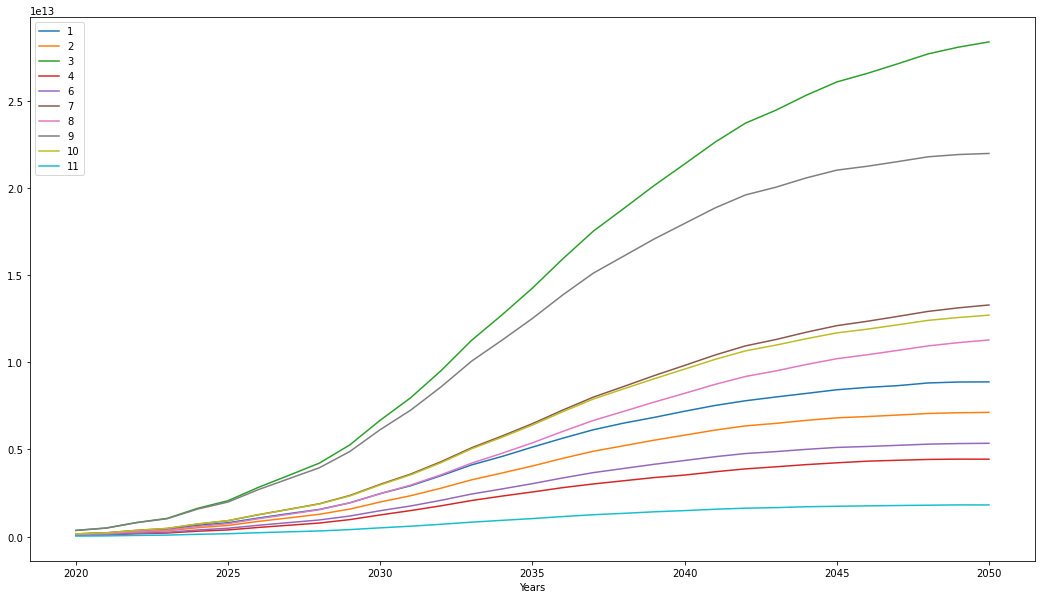

In [60]:
emiles_est_df.drop('5', axis = 1, inplace = True)
emiles_est_df.plot(x = 'Years', y = list(emiles_est_df)[1:], figsize = (18, 10))

In [69]:
electric_est = {}
electric_est['Years'] = future_years
electric_est_df = pd.DataFrame.from_dict(electric_est)
for i in regions:
    if i != 5:
        electric_est_df[str(i)] = emiles_est_df[str(i)]*(306/100000000000000)

<AxesSubplot:xlabel='Years'>

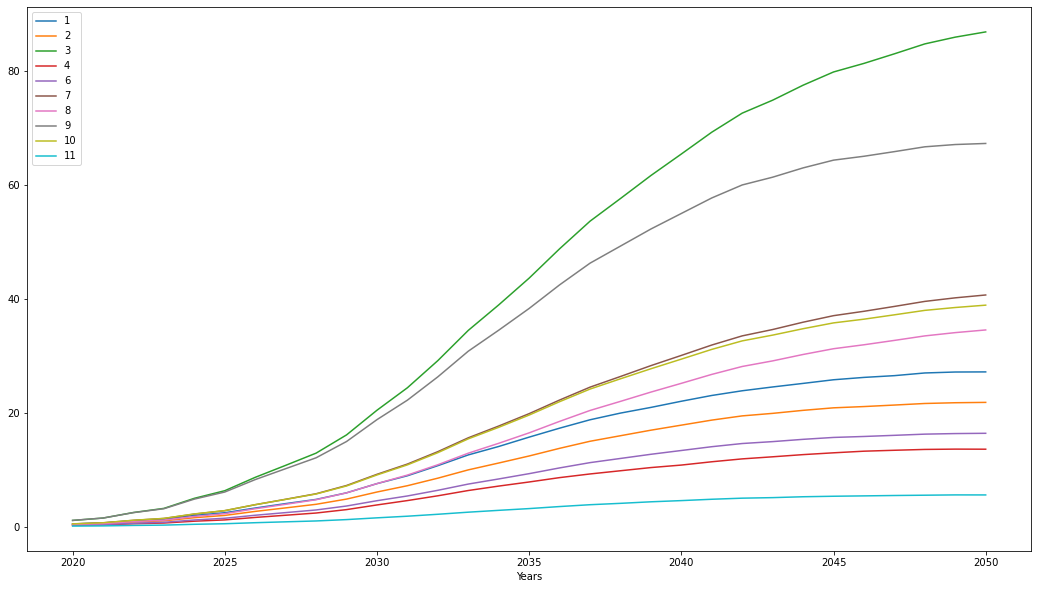

In [70]:
electric_est_df.plot(x = 'Years', y = list(electric_est_df)[1:], figsize = (18, 10))